In [1]:
suppressPackageStartupMessages({
  library(tidyverse)
  library(rbcb)
  library(tidyquant)
  library(bizdays)
})
options(warn = -1)

In [2]:
acao <- "^BVSP"
cdi <- get_series(c(Selic = 1178), start_date = "2001-01-02")
ipca <- get_series(c(IPCA = 433), start_date = xts::first(cdi$date))
ibov <- tq_get(acao, from = xts::first(cdi$date)) %>%
  tq_transmute(select = adjusted, mutate_fun = dailyReturn)
cdi$Selic <- ((cdi$Selic/100)+1)^(1/252)
cdi$Selic <- cdi$Selic-1
ipca$IPCA <- ipca$IPCA/100

In [3]:
meses <- cdi %>%
  mutate(ano = year(date),meses = month(date)) %>%
  group_by(ano,meses) %>%
  summarise(date = first(date))
meses <- cdi %>%
  mutate(ano = year(date),meses = month(date)) %>%
  group_by(ano,meses) %>%
  summarise(date = first(date))
meses$dias <- NA
for(i in 2:nrow(meses)){
  meses$dias[i-1] <- bizdays(meses$date[i-1], meses$date[i], "Brazil/ANBIMA")
}
meses$dias[nrow(meses)] <- bizdays(meses$date[nrow(meses)],
                                   Sys.Date(), "Brazil/ANBIMA")
ipca$date <- meses$date[1:nrow(ipca)]
ipca$dias <- meses$dias[1:nrow(ipca)]

`summarise()` regrouping output by 'ano' (override with `.groups` argument)

`summarise()` regrouping output by 'ano' (override with `.groups` argument)



In [4]:
tot1 <- left_join(cdi,ipca, by = c("date"="date"))
tot1$IPCA[1] <- tot1$IPCA[dplyr::first(which(!is.na(tot1$IPCA)))]
for(i in 2:nrow(tot1)){
  for(j in 1:ncol(tot1)){
    if(is.na(tot1[i,j])){
      tot1[i,j] <- tot1[i-1,j]
    }
  }
}

In [5]:
tot <- left_join(ibov,tot1, by = c("date"="date"))
tot <- na.omit(tot)

In [40]:
data_ref <- "2008-12-01"
tot_ac <- tot %>%
  filter(date >= data_ref) %>%
  group_by(date) %>%
  summarise(Ativo = daily.returns+1, CDI = Selic+1, IPCA = (IPCA+1)^(1/dias))
tot_ac <- apply(tot_ac[,-1],2,cumprod)
tot_ac <- as.data.frame(tot_ac) %>%
  mutate(date = tot$date[tot$date >= data_ref]) %>%
  gather(key = "Ativo", value = "Retorno", -date)

`summarise()` ungrouping output (override with `.groups` argument)



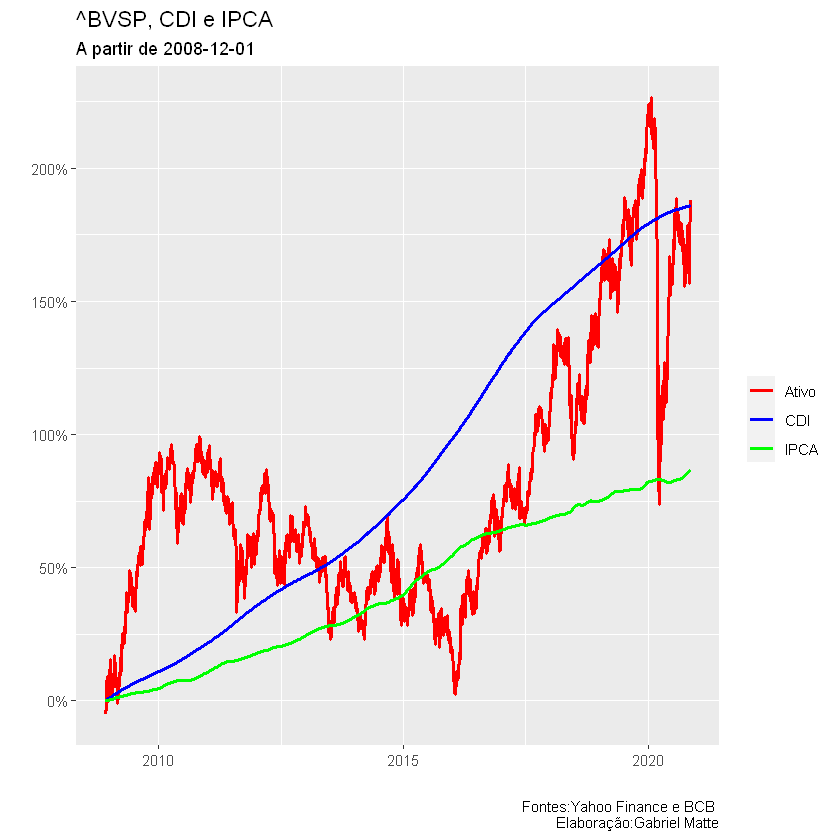

In [41]:
ggplot(tot_ac, aes(x = date, y = Retorno-1, col = Ativo))+
  geom_line(size = 1)+
  scale_y_continuous(labels = scales::percent)+
  labs(x = "", y = "", title = paste0(acao, ", CDI e IPCA"),
       subtitle = paste("A partir de",data_ref),
       caption = "Fontes:Yahoo Finance e BCB \n Elaboração:Gabriel Matte")+
  scale_color_manual("", values = c("red","blue","green"))

In [42]:
ibov_def <- tot_ac %>%
  spread(key = Ativo, value = Retorno) %>%
  group_by(date) %>%
  summarise(Ativo = Ativo/IPCA)

`summarise()` ungrouping output (override with `.groups` argument)



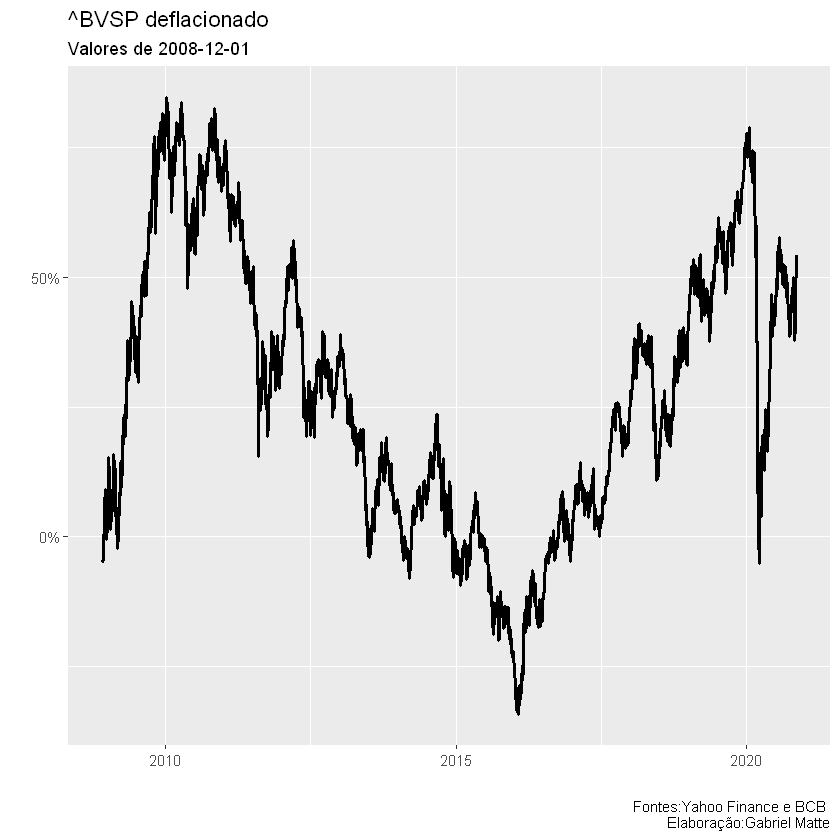

In [43]:
ggplot(ibov_def, aes(x = date, y = Ativo-1))+
  geom_line(size = 1)+
  scale_y_continuous(labels = scales::percent)+
  labs(x = "", y = "", title = paste(acao,"deflacionado"),
       subtitle = paste("Valores de",data_ref),
       caption = "Fontes:Yahoo Finance e BCB \n Elaboração:Gabriel Matte")